<a href="https://colab.research.google.com/github/willywairagu/AICE/blob/master/Swahili_Sentiment_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# setting global seed for reprocibility
SEED = 132
np.random.seed(SEED)


In [2]:
# importing our libraries
train = pd.read_csv('/content/drive/MyDrive/Datasets/EA_Hack/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/Datasets/EA_Hack/Test.csv')
sample = pd.read_csv('/content/drive/MyDrive/Datasets/EA_Hack/sample_submission.csv')

In [3]:
train.head()

,ID,Tweets,Labels
0,2,So chuga si tunakutana kesho kwenye Nyamachoma...,0
1,3,Asante sana watu wa Sirari jimbo la Tarime ...,1
2,5,Leo nimepata kitambulisho changu cha taifa ...,1
3,6,Mgema akisifiwa tembo hulitia maji,0
4,8,Ee Mwenyezi Mungu Msamehe na Umrehemu na Umuaf...,1


In [4]:
test.head()

,ID,Tweets
0,4,Maandalizi Wadau kutoka Kamati ya Maandaliz...
1,7,Tunashukuru sana kwa mrejesho wako kuhusiana n...
2,9,Asante kwa kutembelea kurasa yetu CM
3,10,Habari Asante kwa kutuandikia kupitia kurasa z...
4,15,Kunawa sio wakati wa kula tutujiwekee tarat...


In [5]:
print(train.shape)
print(test.shape)

(2263, 3)
(755, 2)


## EDA

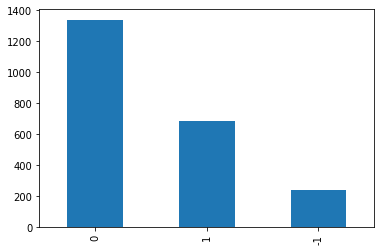

In [6]:
# checking the distribution of our target variable
train.Labels.value_counts().plot(kind='bar')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


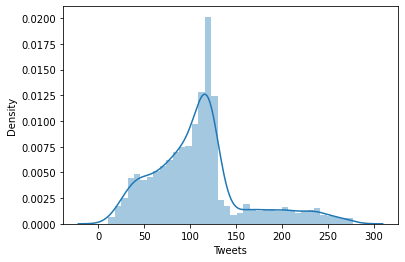

In [7]:
# checking the distribution of our tweets
sns.distplot(train.Tweets.str.len())

plt.show()

minimum length is about 10, maximum between 250 and 300

In [8]:
train.Tweets.str.len().describe()

count    2263.000000
mean      108.833849
std        51.082965
min        11.000000
25%        76.000000
50%       108.000000
75%       123.000000
max       277.000000
Name: Tweets, dtype: float64

**Procedure**
1.   Regular expressions
2.   Tokenization
3.   checking stopwords




In [9]:
import re
from string import punctuation 
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def clean_text(tweet):
    pattern = r'[^a-zA-Z\s]'
    tweet = re.sub(pattern, '', tweet)
    tweet = re.sub(r"[^A-Za-z0-9]", " ", tweet)
    tweet = re.sub('\[.*?\]', '', tweet)  # remove text in square brackets
    tweet = re.sub(r'\b\d+(?:\.\d+)?\s+', '',tweet) # remove numbers
    tweet = re.sub('[‘’“”…]', '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = tweet.lower()  # set in lowercase 
        
    # Remove punctuation from text
    tweet = ''.join([c for c in tweet if c not in punctuation])
    return tweet

stopwords = ['Ee', 'changu', 'kwenye', 'object', 'wa',
            'vya', 'cha', 'kwa', 'sana', 'dont, "Length', 
            'wako', 'wadau','sana', 'ni', 'na', 'au', 'si', 'je', 
            'ee', 'nani', 'je', 'sio', 'ana', 'sijui', 'habari', 
            'cm', 'ambaye', "yetu", "cjui", "juu", "ndio","hu", "tu", 
            "hu", "haya", "za", "kun", "case", "pia", "zetu", "dont", "mambo", ]

# I thought the words related the name of airlines are not relevant to the sentiment analysis
# Therefore I decided to append the above names into the list of stop words.
def clean_stopword(d):
    stop_words = stopwords
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
train['final_tweets'] = train.Tweets.apply(clean_text).apply(clean_stopword).apply(tokenize)
test['final_tweets'] = test.Tweets.apply(clean_text).apply(clean_stopword).apply(tokenize)
# train.final_tweets.head()
test.final_tweets.head()

0    [maandalizi, kutoka, kamati, ya, maandalizi, w...
1    [tunashukuru, mrejesho, kuhusiana, huduma, tut...
2                         [asante, kutembelea, kurasa]
3    [asante, kutuandikia, kupitia, kurasa, tafadha...
4    [kunawa, wakati, kula, tutujiwekee, taratibu, ...
Name: final_tweets, dtype: object

In [11]:
train.final_tweets.head()

0    [so, chuga, tunakutana, kesho, nyamachoma, fes...
1    [asante, watu, sirari, jimbo, la, tarime, viji...
2         [leo, nimepata, kitambulisho, taifa, asante]
3             [mgema, akisifiwa, tembo, hulitia, maji]
4    [mwenyezi, mungu, msamehe, umrehemu, umuafu, m...
Name: final_tweets, dtype: object


### Text Analysis
**Lexicon based approach**

The lexicon-based approach involves calculating orientation for a document from the semantic orientation of words or phrases in the document.it uses dictionaries of words annotated with the word's semantic orientation, or polarity.

Here we will just try to verify the lexicon works hopefully very well to classify the sentiment which has already been allocated by the real customers.

**Vader**

Vader is a lexicon made for the sentiment analysis of text data on social media.

It returns the compounded polarity score of a sentence after calculating the negative, the neutral, and the positive scores of each word in a sentence.

We can use Vader from the innner module in nltk as well as the Python API vaderSentiment.

**VADER**  has many advantages over traditional sentiment analysis methods: source

It works very well with social media type text, but generalizes easily to multiple domains.
It does not require any training data, but consists of a generalized, balence-based, human-curated gold standard psychological vocabulary.
It's fast enough to use online with streaming data,
The speed-performance trade-off isn't serious.

In [12]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()
vader.polarity_scores(" ".join(train.final_tweets[0]))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


{'compound': 0.4939, 'neg': 0.0, 'neu': 0.775, 'pos': 0.225}

In [13]:
texts = [" ".join(train.final_tweets[i]) for i in range(len(train))]

print(train.Tweets[0])
print(texts[0])
print(vader.polarity_scores(texts[0]), f'--> Actual Classification: {train.Labels[0]}', '\n')

print(train.Tweets[1])
print(texts[1])
print(vader.polarity_scores(texts[1]), f'--> Actual Classification: {train.Labels[1]}', '\n')

print(train.Tweets[10])
print(texts[10])
print(vader.polarity_scores(texts[10]), f'--> Actual Classification: {train.Labels[10]}', '\n')

print(train.Tweets[100])
print(texts[100])
print(vader.polarity_scores(texts[100]), f'--> Actual Classification: {train.Labels[100]}', '\n')

print(train.Tweets[1000])
print(texts[1000])
print(vader.polarity_scores(texts[1000]), f'--> Actual Classification: {train.Labels[1000]}', '\n')

print(train.Tweets[2000])
print(texts[2000])
print(vader.polarity_scores(texts[2000]), f'--> Actual Classification: {train.Labels[2000]}')

So chuga si tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe
so chuga tunakutana kesho nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe
{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4939} --> Actual Classification: 0 

   Asante sana watu wa Sirari jimbo la Tarime vijijini Huu ni Upendo usio na Mashaka kwa Mbunge wenu John Heche na Chadem
asante watu sirari jimbo la tarime vijijini huu upendo usio mashaka mbunge wenu john heche chadem
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: 1 

    Takwimu zinaonyesha katika kila watoto 100 27 wanapata mimba kabla ya kufika miaka 18
takwimu zinaonyesha katika kila watoto wanapata mimba kabla ya kufika miaka
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0} --> Actual Classification: 0 

Leo Februari 26 2018 kesi inayomkabili muigizaji imeendelea ambapo Ofisa wa Polisi
leo februari kesi inayomkabili muigizaji imeendelea


### **WordCloud : Keyword analysis¶**

**WordCloud** is one of the easiest way to show which word mainly(frequently) appears in the set of sentences.

But it can be just one of pieces of visulalization if there's no appropriate text preprocessing before drawing it.

In [14]:
# preprocessing before drawing wordcloud separating the sentiment.

positive = train[train.Labels == 1].Tweets.apply(clean_text).apply(clean_stopword).apply(tokenize)
positive = [" ".join(positive.values[i]) for i in range(len(positive))]
positive = [" ".join(positive)][0]

negative = train[train.Labels == -1].Tweets.apply(clean_text).apply(clean_stopword).apply(tokenize)
negative = [" ".join(negative.values[i]) for i in range(len(negative))]
negative = [" ".join(negative)][0]

neutral = train[train.Labels == 0].Tweets.apply(clean_text).apply(clean_stopword).apply(tokenize)
neutral = [" ".join(neutral.values[i]) for i in range(len(neutral))]
neutral = [" ".join(neutral)][0]

print(len(positive), len(negative), len(neutral))

67958 25456 126035


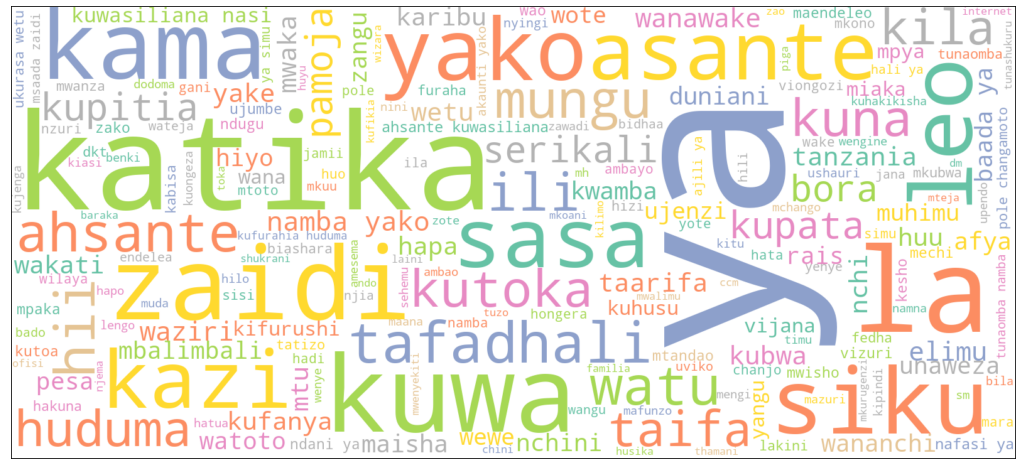

In [15]:
from wordcloud import WordCloud

# POSITIVE
plt.figure(figsize=(18,15))
wc_positive = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(positive)

plt.imshow(wc_positive, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

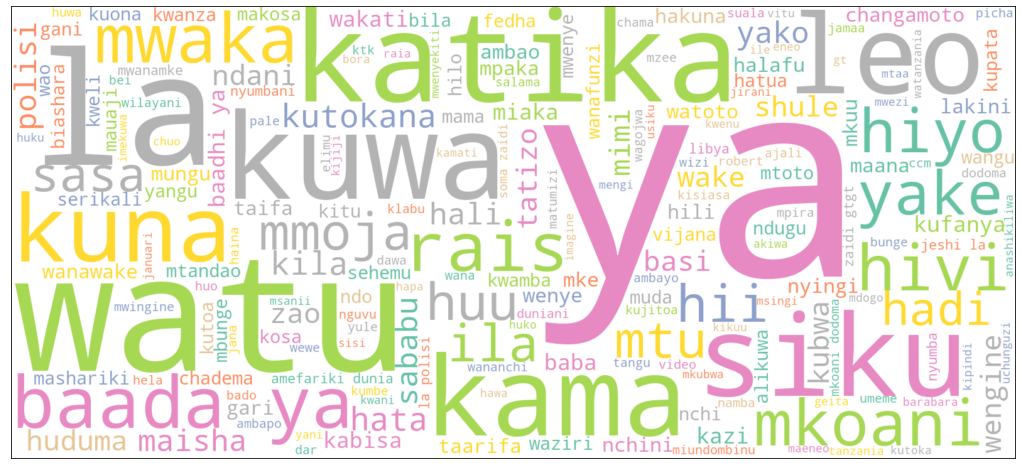

In [16]:
# Negative
plt.figure(figsize=(18,15))
wc_negative = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(negative)

plt.imshow(wc_negative,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

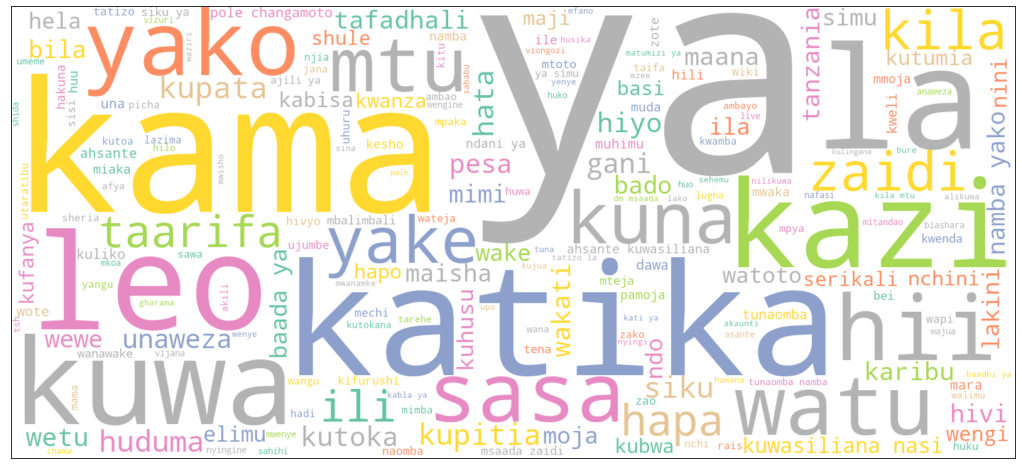

In [17]:
#NEUTRAL
plt.figure(figsize=(18,15))
wc_neutral = WordCloud(min_font_size=3,max_words=200,width=1600,height=720,
                       colormap = 'Set2', background_color='white').generate(neutral)

plt.imshow(wc_neutral,interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.grid(False)

## Modelling


In [18]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [19]:
train.final_tweets.head()

0    [so, chuga, tunakutana, kesho, nyamachoma, fes...
1    [asante, watu, sirari, jimbo, la, tarime, viji...
2         [leo, nimepata, kitambulisho, taifa, asante]
3             [mgema, akisifiwa, tembo, hulitia, maji]
4    [mwenyezi, mungu, msamehe, umrehemu, umuafu, m...
Name: final_tweets, dtype: object

In [20]:
for i in range(len(train)):
    train['final_tweets'][i] = " ".join(train['final_tweets'][i])

for i in range(len(test)):
    test['final_tweets'][i] = " ".join(test['final_tweets'][i])

train['final_tweets'][:3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


0    so chuga tunakutana kesho nyamachoma festival ...
1    asante watu sirari jimbo la tarime vijijini hu...
2               leo nimepata kitambulisho taifa asante
Name: final_tweets, dtype: object

In [21]:
test['final_tweets'][:3]

0    maandalizi kutoka kamati ya maandalizi wajadil...
1    tunashukuru mrejesho kuhusiana huduma tutaifik...
2                             asante kutembelea kurasa
Name: final_tweets, dtype: object

In [22]:
# splitting our feature and labels
X = train.final_tweets
y = train.Labels

In [23]:
model_params = {'random_state':SEED}
model_list = [LogisticRegression(**model_params,C=5,  solver='liblinear', 
                                 class_weight='balanced'),
              RandomForestClassifier(**model_params),
              MultinomialNB(),
              SVC(**model_params, C=0.1, kernel='sigmoid'),
              ExtraTreesClassifier(**model_params),
              XGBRFClassifier(**model_params),
              ]

model_names = ['LogisticRegression', 'RandomForest', 'MultinomialNB', 
               'SupportVectorMachine', 'ExtraTreesClassifier', 'XGBRFClassifier']

c = CountVectorizer(lowercase=False, ngram_range=(1, 2))
X_c = c.fit_transform(X)

tf = TfidfVectorizer(lowercase=False, ngram_range=(1, 2))
X_tf = tf.fit_transform(X)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list, model_names):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(train.index, train.Labels)):        
        X_c_trn = X_c[trn_idx]
        X_tf_trn = X_tf[trn_idx]
        y_trn = train.loc[trn_idx, 'Labels']
        
        X_c_vld = X_c[vld_idx]
        X_tf_vld = X_tf[vld_idx]
        y_vld = train.loc[vld_idx, 'Labels']        
        
        model.fit(X_c_trn, y_trn)
        c_pred_col = f"{model_name}_ct_pred"
        train.loc[vld_idx, c_pred_col] = model.predict(X_c_vld)
        
        model.fit(X_tf_trn, y_trn)
        tf_pred_col = f"{model_name}_tf_pred"
        train.loc[vld_idx, tf_pred_col] = model.predict(X_tf_vld)

    print(f"Model: {model_name}, CountVectorizer, Accuracy: {accuracy_score(train.Labels, train[c_pred_col]):.3%}")
    print(f"Model: {model_name}, TfidfVectorizer, Accuracy: {accuracy_score(train.Labels, train[tf_pred_col]):.3%}\n")

Model: LogisticRegression, CountVectorizer, Accuracy: 59.479%
Model: LogisticRegression, TfidfVectorizer, Accuracy: 60.672%

Model: RandomForest, CountVectorizer, Accuracy: 59.567%
Model: RandomForest, TfidfVectorizer, Accuracy: 59.523%

Model: MultinomialNB, CountVectorizer, Accuracy: 49.890%
Model: MultinomialNB, TfidfVectorizer, Accuracy: 59.479%

Model: SupportVectorMachine, CountVectorizer, Accuracy: 59.213%
Model: SupportVectorMachine, TfidfVectorizer, Accuracy: 59.213%

Model: ExtraTreesClassifier, CountVectorizer, Accuracy: 59.523%
Model: ExtraTreesClassifier, TfidfVectorizer, Accuracy: 59.523%

Model: XGBRFClassifier, CountVectorizer, Accuracy: 60.495%
Model: XGBRFClassifier, TfidfVectorizer, Accuracy: 60.230%



In [24]:
# preprocessing our test set
test_transformed_tf = tf.transform(test['final_tweets'].astype('str'))
model = model_list[4]
preds = model.predict(test_transformed_tf)
preds

array([ 0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0, -1,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,
        0,  1,  0,  0,  1

In [25]:
# creating a submission file
sub_file = pd.DataFrame()
sub_file['ID'] = test.ID
sub_file['Tweets'] = preds
sub_file.to_csv('XGBRF_CV_TFIDF.csv', index=False)
sub_file.head()

,ID,Tweets
0,4,0
1,7,1
2,9,0
3,10,1
4,15,0


**Word2Vec**

Word2Vec is one of the most popular model to represent a word in a large text corpus as a vector in n-dimensional space.

There are two kinds of W2V, Continuous Bag-of-Words(CBOW) and Skip-Gram.

Skip-gram is used to predict the context word for a given target word. It’s reverse of CBOW algorithm. Here, target word is input while context words are output.

In most case it is known that the predictability of skip-gram is better than the one of CBOW.

We can use Word2Vec library from gensim and set the option sg which is the abbreviation of skip-gram.

1, if you want to set skip-gram and 0 for CBOW.

In [26]:
from gensim.models import Word2Vec

texts_w2v = train.final_tweets.apply(tokenize).to_list()
# texts_w2v_test = test.final_tweets.apply(tokenize).to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3, min_count = 5, workers = 4, sg = 1)
# w2v_test = Word2Vec(sentences = texts_w2v_test, window = 3, min_count = 5, workers = 4, sg = 1)

In [27]:
texts_w2v[:3]

[['so',
  'chuga',
  'tunakutana',
  'kesho',
  'nyamachoma',
  'festival',
  'nanenanemnajifanyaga',
  'mnakula',
  'mtungi',
  'mje',
  'kesho',
  'niwakalishe'],
 ['asante',
  'watu',
  'sirari',
  'jimbo',
  'la',
  'tarime',
  'vijijini',
  'huu',
  'upendo',
  'usio',
  'mashaka',
  'mbunge',
  'wenu',
  'john',
  'heche',
  'chadem'],
 ['leo', 'nimepata', 'kitambulisho', 'taifa', 'asante']]

Word2Vec imported from gensim trains the texts at the same time as it is declared by the user.

We can find the similar words with the given word and the examples are represented below.

In [28]:
w2v.wv.most_similar('asante')

[('bado', 0.9995269775390625),
 ('huduma', 0.9995229244232178),
 ('mteja', 0.9995216131210327),
 ('basi', 0.9995213747024536),
 ('kupata', 0.9995116591453552),
 ('kufahamu', 0.999504566192627),
 ('sehemu', 0.999485969543457),
 ('ujumbe', 0.9994856715202332),
 ('bila', 0.9994552135467529),
 ('kifurushi', 0.9994489550590515)]

In [29]:
w2v.wv.most_similar('katika')

[('fursa', 0.9996740818023682),
 ('sasa', 0.99964439868927),
 ('hapo', 0.9996398687362671),
 ('wangu', 0.9996353983879089),
 ('hela', 0.9996227025985718),
 ('mpaka', 0.9996224641799927),
 ('mwezi', 0.9996073842048645),
 ('upande', 0.9996065497398376),
 ('nchi', 0.999605119228363),
 ('nini', 0.9996014833450317)]

In [30]:
w2v.wv.most_similar('tanzania')

[('hilo', 0.9996342658996582),
 ('maji', 0.9996131658554077),
 ('kuendelea', 0.9995951056480408),
 ('shule', 0.9995933771133423),
 ('hapa', 0.9995865821838379),
 ('zako', 0.9995827674865723),
 ('kilimo', 0.9995813965797424),
 ('kweli', 0.9995713233947754),
 ('wao', 0.9995707273483276),
 ('mkoani', 0.9995698928833008)]

In [31]:
w2v.wv.most_similar('ya')

[('watoto', 0.9993641376495361),
 ('kesho', 0.9993605613708496),
 ('rais', 0.9993597269058228),
 ('mimba', 0.9993571043014526),
 ('nzuri', 0.9993409514427185),
 ('nini', 0.9993377327919006),
 ('nchini', 0.9993330240249634),
 ('tarehe', 0.999326229095459),
 ('mkoa', 0.999325692653656),
 ('huwa', 0.9993217587471008)]

In [32]:
def get_avg_vector(sent):
    vector = np.zeros(100)
    total_words = 0

    for word in sent.split():        
        if word in w2v.wv.vocab:    # don't use .wv.vocab method in kaggle notebook. instead, use .wv.index_to_key method.
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector
    
train['w2v_vector'] = train['final_tweets'].map(get_avg_vector)
test['w2v_vector'] = test['final_tweets'].map(get_avg_vector)
train[['final_tweets', 'w2v_vector']].head(2)

,final_tweets,w2v_vector
0,so chuga tunakutana kesho nyamachoma festival ...,"[-0.1473473533987999, -0.08026455342769623, -0..."
1,asante watu sirari jimbo la tarime vijijini hu...,"[-0.14875422343611716, -0.07585641257464885, -..."


In [33]:
test[['final_tweets', 'w2v_vector']].head(2)

,final_tweets,w2v_vector
0,maandalizi kutoka kamati ya maandalizi wajadil...,"[-0.17871805363231236, -0.09108937448925442, -..."
1,tunashukuru mrejesho kuhusiana huduma tutaifik...,"[-0.14064675848931074, -0.07101677590981126, -..."


In [34]:
model_params = {'random_state':SEED}
model_list2 = [LogisticRegression(**model_params,C=5,  solver='liblinear', 
                                 class_weight='balanced'),
              RandomForestClassifier(**model_params),
              # MultinomialNB(),
              SVC(**model_params, C=0.1, kernel='sigmoid'),
              ExtraTreesClassifier(**model_params),
              XGBRFClassifier(**model_params),
              ]
model_names2 = ['LogisticRegression', 'RandomForest', 
                            # 'MultinomialNB', 
               'SupportVectorMachine', 'ExtraTreesClassifier', 'XGBRFClassifier']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model, model_name in zip(model_list2, model_names2):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(train.index, train.Labels)):        
        X_trn = np.stack(train.loc[trn_idx, 'w2v_vector'])
        y_trn = train.loc[trn_idx, 'Labels']
        
        X_vld = np.stack(train.loc[vld_idx, 'w2v_vector'])
        y_vld = train.loc[vld_idx, 'Labels']        
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        train.loc[vld_idx, pred_col] = model.predict(X_vld)
        

    print(f"Model: {model_name}, Word2Vec, Accuracy: {accuracy_score(train.Labels, train[pred_col]):.3%}\n")

Model: LogisticRegression, Word2Vec, Accuracy: 59.213%

Model: RandomForest, Word2Vec, Accuracy: 58.506%

Model: SupportVectorMachine, Word2Vec, Accuracy: 58.860%

Model: ExtraTreesClassifier, Word2Vec, Accuracy: 58.551%

Model: XGBRFClassifier, Word2Vec, Accuracy: 59.081%



In [35]:
# preprocessing our test set
# test['word2Vec'] = test['final_tweets'].astype('str').map(get_avg_vector)
model = model_list2[3]
preds = model.predict(np.stack(test.loc[:, 'w2v_vector']))
preds

array([ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  0,  0,  0

In [36]:
# creating a submission file
sub_file = pd.DataFrame()
sub_file['ID'] = test.ID
sub_file['Tweets'] = preds
sub_file.to_csv('EXTRAtrees_CV_W2V.csv', index=False)
sub_file.head()

,ID,Tweets
0,4,0
1,7,0
2,9,0
3,10,1
4,15,0


### LSTM

In [37]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional,Embedding, Dropout, Conv1D, MaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

In [38]:
max_words = 5000
max_len = 100

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', train['final_tweets'][0],'\n')
X, tokenizer = tokenize_pad_sequences(train['final_tweets'])
test_tockenized , test_tokenizer= tokenize_pad_sequences(test['final_tweets'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 so chuga tunakutana kesho nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe 

After Tokenization & Padding 
 [ 679 1965 3173   90 1966 1398 3174 3175 3176 3177   90 3178    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [39]:
y = pd.get_dummies(train.Labels)
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, test_size=0.3, random_state=42, stratify=y_trn)

print('Train:         ', X_trn.shape, y_trn.shape)
print('Validation Set:', X_vld.shape, y_vld.shape)
print('Test Set:      ', X_tst.shape, y_tst.shape)

Train:          (1267, 100) (1267, 3)
Validation Set: (543, 100) (543, 3)
Test Set:       (453, 100) (453, 3)


In [40]:
vocab_size = 5000
embedding_size = 32
epochs=50

model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

# plot_model(model, show_shapes = True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [41]:
es = EarlyStopping(monitor = 'val_loss', patience=5)
batch_size = 64

history = model.fit(X_trn, y_trn,
                    validation_data=(X_vld, y_vld),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    callbacks = [es])

Epoch 1/50
20/20 [==============================] - 7s 109ms/step - loss: 1.0178 - accuracy: 0.5454 - val_loss: 0.9178 - val_accuracy: 0.5930
Epoch 2/50
20/20 [==============================] - 1s 55ms/step - loss: 0.9167 - accuracy: 0.5919 - val_loss: 0.9065 - val_accuracy: 0.5930
Epoch 3/50
20/20 [==============================] - 1s 54ms/step - loss: 0.9046 - accuracy: 0.5919 - val_loss: 0.9069 - val_accuracy: 0.5930
Epoch 4/50
20/20 [==============================] - 1s 53ms/step - loss: 0.8945 - accuracy: 0.5919 - val_loss: 0.9007 - val_accuracy: 0.5930
Epoch 5/50
20/20 [==============================] - 1s 54ms/step - loss: 0.8576 - accuracy: 0.5983 - val_loss: 0.8914 - val_accuracy: 0.5930
Epoch 6/50
20/20 [==============================] - 1s 53ms/step - loss: 0.7080 - accuracy: 0.7032 - val_loss: 0.8882 - val_accuracy: 0.5985
Epoch 7/50
20/20 [==============================] - 1s 53ms/step - loss: 0.5011 - accuracy: 0.8240 - val_loss: 0.9758 - val_accuracy: 0.5341
Epoch 8/50
2

In [42]:
# Evaluate model on the test set
loss, accuracy = model.evaluate(X_tst, y_tst, verbose=0)

# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.5320


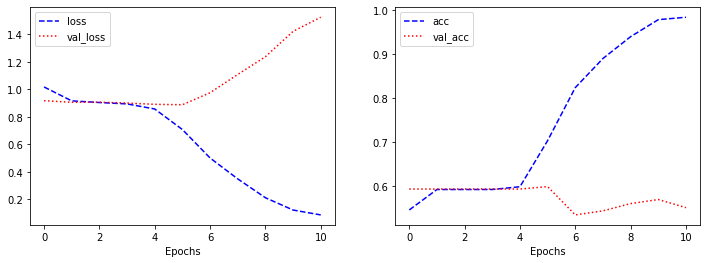

In [43]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

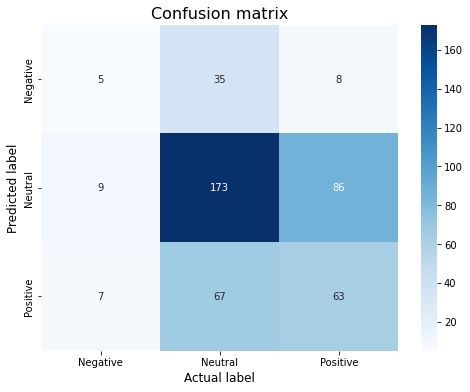

In [44]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_tst, y_tst)

In [45]:
# doing our prediction
predictions = model.predict(test_tockenized)
len(predictions)

755

In [46]:
preds = list(np.argmax(predictions, axis=1))
# preds

In [47]:
test['Labels'] = preds
test.head()

,ID,Tweets,final_tweets,w2v_vector,Labels
0,4,Maandalizi Wadau kutoka Kamati ya Maandaliz...,maandalizi kutoka kamati ya maandalizi wajadil...,"[-0.17871805363231236, -0.09108937448925442, -...",1
1,7,Tunashukuru sana kwa mrejesho wako kuhusiana n...,tunashukuru mrejesho kuhusiana huduma tutaifik...,"[-0.14064675848931074, -0.07101677590981126, -...",1
2,9,Asante kwa kutembelea kurasa yetu CM,asante kutembelea kurasa,"[-0.13006328294674555, -0.06365703543027242, -...",1
3,10,Habari Asante kwa kutuandikia kupitia kurasa z...,asante kutuandikia kupitia kurasa tafadhali tu...,"[-0.15260136184784082, -0.07478847383306576, -...",1
4,15,Kunawa sio wakati wa kula tutujiwekee tarat...,kunawa wakati kula tutujiwekee taratibu kunawa...,"[-0.15068213492631913, -0.0760847769677639, -0...",1


In [48]:
mapper = {
    0:-1,
    1:0,
    2:1,
}

test['Labels'] = test.Labels.map(mapper)
final_sub2 = pd.DataFrame()
final_sub2['ID'] = test.ID
final_sub2['Labels'] = test.Labels
final_sub2.to_csv("LSTM_base.csv", index=False)
final_sub2


,ID,Labels
0,4,0
1,7,0
2,9,0
3,10,0
4,15,0
...,...,...
750,3004,0
751,3005,0
752,3007,0
753,3015,1
